In [1]:
conda init

no change     /Users/aesthetic/opt/anaconda3/condabin/conda
no change     /Users/aesthetic/opt/anaconda3/bin/conda
no change     /Users/aesthetic/opt/anaconda3/bin/conda-env
no change     /Users/aesthetic/opt/anaconda3/bin/activate
no change     /Users/aesthetic/opt/anaconda3/bin/deactivate
no change     /Users/aesthetic/opt/anaconda3/etc/profile.d/conda.sh
no change     /Users/aesthetic/opt/anaconda3/etc/fish/conf.d/conda.fish
no change     /Users/aesthetic/opt/anaconda3/shell/condabin/Conda.psm1
no change     /Users/aesthetic/opt/anaconda3/shell/condabin/conda-hook.ps1
no change     /Users/aesthetic/opt/anaconda3/lib/python3.8/site-packages/xontrib/conda.xsh
no change     /Users/aesthetic/opt/anaconda3/etc/profile.d/conda.csh
no change     /Users/aesthetic/.bash_profile
No action taken.

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install alpha_vantage pandas


Note: you may need to restart the kernel to use updated packages.


In [3]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from alpha_vantage.techindicators import TechIndicators
from datetime import date
from datetime import timedelta

import matplotlib.pyplot as plt 
import sys
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report


import numpy as np



In [4]:
# Obtaining stock data from alpha vantage 
sym='AAPL'




ticker_list=['MS', 'BT-A.L', 'TSLA', 'PFE' ]
# 'BT-A.L', 'TSLA', 'PFE'
column_names=['1. open', '2. high', '3. low', '4. close', '5. adjusted close', '6. volume', 
               '7. dividend amount', '8. split coefficient', 'Ticker']
#obtains stock data from the previous day date to 2018-11-29


def stock_data(sym):
    ts = TimeSeries(key='SUXOFAIGXM6HEP9Y', output_format='pandas')
    data, meta_data = ts.get_daily_adjusted(symbol=sym, outputsize='full')
    data_date_changed = data[:'2019-01-01']
    data_date_changed['Ticker']= sym
    return data_date_changed


data_dated = pd.DataFrame(columns = column_names)


for ticker in ticker_list:
    data_dated = data_dated.append(stock_data(ticker), sort=False)


<ipython-input-4-50d4edb1b606>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_date_changed['Ticker']= sym


# Identify Anomalies

In [5]:
print('The shape of our data is:', data_dated.shape)

The shape of our data is: (2140, 9)


In [6]:
data_dated.isna().any()

1. open                 False
2. high                 False
3. low                  False
4. close                False
5. adjusted close       False
6. volume               False
7. dividend amount      False
8. split coefficient    False
Ticker                  False
dtype: bool

In [7]:
data_dated.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker
2021-02-12,73.88,75.020,73.88,74.61,74.61,7281192.0,0.0,1.0,MS
2021-02-11,74.33,74.770,72.78,73.72,73.72,6972883.0,0.0,1.0,MS
2021-02-10,74.60,74.865,73.55,74.33,74.33,7180859.0,0.0,1.0,MS
2021-02-09,73.90,74.680,73.37,74.24,74.24,7323686.0,0.0,1.0,MS
2021-02-08,73.64,74.290,73.40,74.23,74.23,9018095.0,0.0,1.0,MS


In [8]:

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

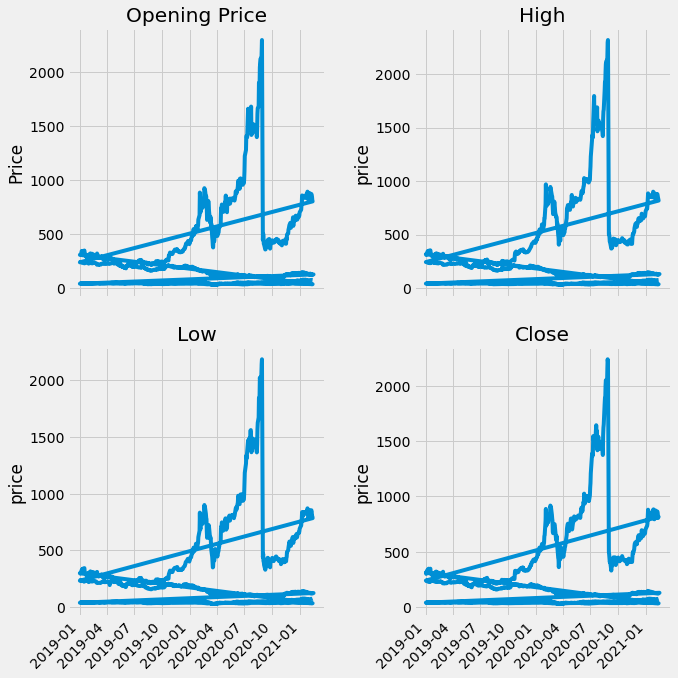

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# opening price
ax1.plot(data_dated.index, data_dated['1. open'])
ax1.set_xlabel(''); ax1.set_ylabel('Price'); ax1.set_title('Opening Price')


ax2.plot(data_dated.index, data_dated['2. high'])
ax2.set_xlabel(''); ax2.set_ylabel('price'); ax2.set_title('High')


ax3.plot(data_dated.index, data_dated['3. low'])
ax3.set_xlabel(''); ax3.set_ylabel('price'); ax3.set_title('Low')

ax4.plot(data_dated.index, data_dated['4. close'])
ax4.set_xlabel(''); ax4.set_ylabel('price'); ax4.set_title('Close')


plt.tight_layout(pad=2)


In [10]:
data_dated[data_dated.duplicated()]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker


One Hot Encoding 

# data_dated.tail()

In [11]:
data_dated['date']= data_dated.index

In [12]:
data_dated.sort_index(inplace=True)
data_dated.sort_values(by = ['Ticker','date'], inplace = True)


data_dated['change_in_price']= data_dated['4. close'].diff()

In [13]:
mask = data_dated['Ticker'] != data_dated['Ticker'].shift(1)

data_dated['change_in_price']= np.where(mask==True, np.nan, data_dated['change_in_price'])

data_dated[data_dated.isna().any(axis=1)]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,date,change_in_price
2019-01-02,237.00,242.20,233.25,240.00,220.802700,20278421.0,0.0,1.0,BT-A.L,2019-01-02,NaN
2019-01-02,39.02,40.72,38.76,40.40,37.935801,10648013.0,0.0,1.0,MS,2019-01-02,NaN
2019-01-02,43.12,43.50,42.64,43.25,37.587547,25076212.0,0.0,1.0,PFE,2019-01-02,NaN
2019-01-02,306.10,315.13,298.80,310.12,62.024000,11658600.0,0.0,1.0,TSLA,2019-01-02,NaN


In [14]:
data_dated['day'] = data_dated.index.day
data_dated['month'] = data_dated.index.month
data_dated['year'] = data_dated.index.year

In [15]:
data_dated.reset_index(inplace=True)

In [16]:
data_dated.head(20)

,index,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,date,change_in_price,day,month,year
0,2019-01-02,237.00,242.20,233.250,240.00,220.8027,20278421.0,0.0,1.0,BT-A.L,2019-01-02,NaN,2,1,2019
1,2019-01-03,240.10,242.60,237.550,240.10,220.8947,13975097.0,0.0,1.0,BT-A.L,2019-01-03,0.10,3,1,2019
2,2019-01-04,241.00,241.90,236.450,237.35,218.3646,19484073.0,0.0,1.0,BT-A.L,2019-01-04,-2.75,4,1,2019
3,2019-01-07,239.95,242.00,237.066,237.95,218.9167,15507525.0,0.0,1.0,BT-A.L,2019-01-07,0.60,7,1,2019
4,2019-01-08,237.75,238.90,229.400,231.00,212.5226,26557234.0,0.0,1.0,BT-A.L,2019-01-08,-6.95,8,1,2019
5,2019-01-09,232.30,234.85,230.550,232.50,213.9026,25148123.0,0.0,1.0,BT-A.L,2019-01-09,1.50,9,1,2019
6,2019-01-10,232.70,234.70,231.850,233.55,214.8686,17643904.0,0.0,1.0,BT-A.L,2019-01-10,1.05,10,1,2019
7,2019-01-11,233.75,236.35,232.500,233.05,214.4086,46248643.0,0.0,1.0,BT-A.L,2019-01-11,-0.50,11,1,2019
8,2019-01-14,232.85,233.15,228.050,228.60,210.3146,50697635.0,0.0,1.0,BT-A.L,2019-01-14,-4.45,14,1,2019
9,2019-01-15,231.65,232.25,229.100,229.95,211.5566,17775775.0,0.0,1.0,BT-A.L,2019-01-15,1.35,15,1,2019


In [17]:
days_out= 30

data_dated_smoothed = data_dated.groupby(['Ticker'])[['1. open','2. high','3. low','4. close','6. volume','day', 'month', 'year', 'change_in_price']].transform(lambda x: x.ewm(span = days_out).mean())

smoothed_df = pd.concat([data_dated[['Ticker','date']], data_dated_smoothed], axis=1, sort=False)

In [18]:
# define the number of days out you want to predict
days_out = 30

# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
smoothed_df['Signal_Flag'] = smoothed_df.groupby('Ticker')['4. close'].transform(lambda x : np.sign(x.diff(days_out)))

# print the first 50 rows
smoothed_df.head(50)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,change_in_price,Signal_Flag
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,2.000000,1.000000,2019.0,NaN,NaN
1,BT-A.L,2019-01-03,238.601667,242.406667,235.471667,240.051667,1.702170e+07,2.516667,1.000000,2019.0,0.100000,NaN
2,BT-A.L,2019-01-04,239.454980,242.226398,235.819752,239.090429,1.789780e+07,3.044428,1.000000,2019.0,-1.372500,NaN
3,BT-A.L,2019-01-07,239.591376,242.164017,236.163139,238.776200,1.723919e+07,4.134332,1.000000,2019.0,-0.670696,NaN
4,BT-A.L,2019-01-08,239.172418,241.421374,234.624361,237.006926,1.935927e+07,5.013865,1.000000,2019.0,-2.400873,NaN
5,BT-A.L,2019-01-09,237.827938,240.135788,233.827276,236.125217,2.049177e+07,5.793690,1.000000,2019.0,-1.513330,NaN
6,BT-A.L,2019-01-10,236.941028,239.195633,233.485294,235.679816,1.999921e+07,6.521198,1.000000,2019.0,-1.011855,NaN
7,BT-A.L,2019-01-11,236.443113,238.751612,233.331552,235.269471,2.409507e+07,7.220052,1.000000,2019.0,-0.923326,NaN
8,BT-A.L,2019-01-14,235.929467,237.950845,232.576539,234.316050,2.789798e+07,8.189266,1.000000,2019.0,-1.473614,NaN
9,BT-A.L,2019-01-15,235.362199,237.195166,232.115704,233.737306,2.655623e+07,9.092067,1.000000,2019.0,-1.069970,NaN


In [19]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = smoothed_df[['Ticker','change_in_price']].copy(), smoothed_df[['Ticker','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
smoothed_df['down_days'] = down_df['change_in_price']
smoothed_df['up_days'] = up_df['change_in_price']
smoothed_df['RSI'] = relative_strength_index

# Display the head.
smoothed_df.head(30)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,change_in_price,Signal_Flag,down_days,up_days,RSI
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,2.000000,1.000000,2019.0,NaN,NaN,NaN,NaN,NaN
1,BT-A.L,2019-01-03,238.601667,242.406667,235.471667,240.051667,1.702170e+07,2.516667,1.000000,2019.0,0.100000,NaN,0.000000,0.100000,100.000000
2,BT-A.L,2019-01-04,239.454980,242.226398,235.819752,239.090429,1.789780e+07,3.044428,1.000000,2019.0,-1.372500,NaN,1.372500,0.000000,5.939463
3,BT-A.L,2019-01-07,239.591376,242.164017,236.163139,238.776200,1.723919e+07,4.134332,1.000000,2019.0,-0.670696,NaN,0.670696,0.000000,3.881095
4,BT-A.L,2019-01-08,239.172418,241.421374,234.624361,237.006926,1.935927e+07,5.013865,1.000000,2019.0,-2.400873,NaN,2.400873,0.000000,1.596225
5,BT-A.L,2019-01-09,237.827938,240.135788,233.827276,236.125217,2.049177e+07,5.793690,1.000000,2019.0,-1.513330,NaN,1.513330,0.000000,1.117669
6,BT-A.L,2019-01-10,236.941028,239.195633,233.485294,235.679816,1.999921e+07,6.521198,1.000000,2019.0,-1.011855,NaN,1.011855,0.000000,0.907717
7,BT-A.L,2019-01-11,236.443113,238.751612,233.331552,235.269471,2.409507e+07,7.220052,1.000000,2019.0,-0.923326,NaN,0.923326,0.000000,0.757830
8,BT-A.L,2019-01-14,235.929467,237.950845,232.576539,234.316050,2.789798e+07,8.189266,1.000000,2019.0,-1.473614,NaN,1.473614,0.000000,0.581121
9,BT-A.L,2019-01-15,235.362199,237.195166,232.115704,233.737306,2.655623e+07,9.092067,1.000000,2019.0,-1.069970,NaN,1.069970,0.000000,0.486150


In [20]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = smoothed_df[['Ticker','3. low']].copy(), smoothed_df[['Ticker','2. high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('Ticker')['3. low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['2. high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((smoothed_df['4. close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
smoothed_df['low_14'] = low_14
smoothed_df['high_14'] = high_14
smoothed_df['k_percent'] = k_percent

# Display the head.
smoothed_df.head(5)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,change_in_price,Signal_Flag,down_days,up_days,RSI,low_14,high_14,k_percent
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,2.000000,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BT-A.L,2019-01-03,238.601667,242.406667,235.471667,240.051667,1.702170e+07,2.516667,1.0,2019.0,0.100000,NaN,0.000000,0.1,100.000000,NaN,NaN,NaN
2,BT-A.L,2019-01-04,239.454980,242.226398,235.819752,239.090429,1.789780e+07,3.044428,1.0,2019.0,-1.372500,NaN,1.372500,0.0,5.939463,NaN,NaN,NaN
3,BT-A.L,2019-01-07,239.591376,242.164017,236.163139,238.776200,1.723919e+07,4.134332,1.0,2019.0,-0.670696,NaN,0.670696,0.0,3.881095,NaN,NaN,NaN
4,BT-A.L,2019-01-08,239.172418,241.421374,234.624361,237.006926,1.935927e+07,5.013865,1.0,2019.0,-2.400873,NaN,2.400873,0.0,1.596225,NaN,NaN,NaN


In [21]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = smoothed_df[['Ticker','3. low']].copy(), smoothed_df[['Ticker','2. high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('Ticker')['3. low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['2. high'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - smoothed_df['4. close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
smoothed_df['r_percent'] = r_percent

# Display the head.
smoothed_df.head(5)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,change_in_price,Signal_Flag,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,2.000000,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BT-A.L,2019-01-03,238.601667,242.406667,235.471667,240.051667,1.702170e+07,2.516667,1.0,2019.0,0.100000,NaN,0.000000,0.1,100.000000,NaN,NaN,NaN,NaN
2,BT-A.L,2019-01-04,239.454980,242.226398,235.819752,239.090429,1.789780e+07,3.044428,1.0,2019.0,-1.372500,NaN,1.372500,0.0,5.939463,NaN,NaN,NaN,NaN
3,BT-A.L,2019-01-07,239.591376,242.164017,236.163139,238.776200,1.723919e+07,4.134332,1.0,2019.0,-0.670696,NaN,0.670696,0.0,3.881095,NaN,NaN,NaN,NaN
4,BT-A.L,2019-01-08,239.172418,241.421374,234.624361,237.006926,1.935927e+07,5.013865,1.0,2019.0,-2.400873,NaN,2.400873,0.0,1.596225,NaN,NaN,NaN,NaN


In [22]:
# Calculate the MACD
ema_26 = smoothed_df.groupby('Ticker')['4. close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = smoothed_df.groupby('Ticker')['4. close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
smoothed_df['MACD'] = macd
smoothed_df['MACD_EMA'] = ema_9_macd

# Print the head.
smoothed_df.head(5)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,...,Signal_Flag,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,2.000000,1.0,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,BT-A.L,2019-01-03,238.601667,242.406667,235.471667,240.051667,1.702170e+07,2.516667,1.0,2019.0,...,NaN,0.000000,0.1,100.000000,NaN,NaN,NaN,NaN,0.001159,0.000644
2,BT-A.L,2019-01-04,239.454980,242.226398,235.819752,239.090429,1.789780e+07,3.044428,1.0,2019.0,...,NaN,1.372500,0.0,5.939463,NaN,NaN,NaN,NaN,-0.028331,-0.011231
3,BT-A.L,2019-01-07,239.591376,242.164017,236.163139,238.776200,1.723919e+07,4.134332,1.0,2019.0,...,NaN,0.670696,0.0,3.881095,NaN,NaN,NaN,NaN,-0.052394,-0.025175
4,BT-A.L,2019-01-08,239.172418,241.421374,234.624361,237.006926,1.935927e+07,5.013865,1.0,2019.0,...,NaN,2.400873,0.0,1.596225,NaN,NaN,NaN,NaN,-0.134771,-0.057777


In [23]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
smoothed_df['Price_Rate_Of_Change'] = smoothed_df.groupby('Ticker')['4. close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
smoothed_df.head(5)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,...,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,2.000000,1.0,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,BT-A.L,2019-01-03,238.601667,242.406667,235.471667,240.051667,1.702170e+07,2.516667,1.0,2019.0,...,0.000000,0.1,100.000000,NaN,NaN,NaN,NaN,0.001159,0.000644,NaN
2,BT-A.L,2019-01-04,239.454980,242.226398,235.819752,239.090429,1.789780e+07,3.044428,1.0,2019.0,...,1.372500,0.0,5.939463,NaN,NaN,NaN,NaN,-0.028331,-0.011231,NaN
3,BT-A.L,2019-01-07,239.591376,242.164017,236.163139,238.776200,1.723919e+07,4.134332,1.0,2019.0,...,0.670696,0.0,3.881095,NaN,NaN,NaN,NaN,-0.052394,-0.025175,NaN
4,BT-A.L,2019-01-08,239.172418,241.421374,234.624361,237.006926,1.935927e+07,5.013865,1.0,2019.0,...,2.400873,0.0,1.596225,NaN,NaN,NaN,NaN,-0.134771,-0.057777,NaN


In [24]:
def obv(group):

    # Grab the volume and close column.
    volume = group['6. volume']
    change = group['4. close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series.
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = smoothed_df.groupby('Ticker').apply(obv)

# add to the data frame, but drop the old index, before adding it.
smoothed_df['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

# display the data frame.
smoothed_df.head(5)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,...,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,2.000000,1.0,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000e+00
1,BT-A.L,2019-01-03,238.601667,242.406667,235.471667,240.051667,1.702170e+07,2.516667,1.0,2019.0,...,0.1,100.000000,NaN,NaN,NaN,NaN,0.001159,0.000644,NaN,1.702170e+07
2,BT-A.L,2019-01-04,239.454980,242.226398,235.819752,239.090429,1.789780e+07,3.044428,1.0,2019.0,...,0.0,5.939463,NaN,NaN,NaN,NaN,-0.028331,-0.011231,NaN,-8.760966e+05
3,BT-A.L,2019-01-07,239.591376,242.164017,236.163139,238.776200,1.723919e+07,4.134332,1.0,2019.0,...,0.0,3.881095,NaN,NaN,NaN,NaN,-0.052394,-0.025175,NaN,-1.811529e+07
4,BT-A.L,2019-01-08,239.172418,241.421374,234.624361,237.006926,1.935927e+07,5.013865,1.0,2019.0,...,0.0,1.596225,NaN,NaN,NaN,NaN,-0.134771,-0.057777,NaN,-3.747456e+07


In [25]:
# # Create a column we wish to predict
# '''
#     In this case, let's create an output column that will be 1 if the closing price at time 't' is greater than 't-1' and 0 otherwise.
#     In other words, if the today's closing price is greater than yesterday's closing price it would be 1.
# '''

# # Group by the `Symbol` column, then grab the `Close` column.
# close_groups = data_dated.groupby('Ticker')['4. close']

# # Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
# close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# # add the data to the main dataframe.
# data_dated['Prediction'] = close_groups

# # for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
# data_dated.loc[data_dated['Prediction'] == 0.0] = 1.0

# # print the head
# data_dated.head(5)

# # OPTIONAL CODE: Dump the data frame to a CSV file to examine the data yourself.
# # price_data.to_csv('final_metrics.csv')

In [26]:
data_dated.tail(10)

,index,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,date,change_in_price,day,month,year
2130,2021-02-01,814.290,842.0000,795.5601,839.81,839.81,25391385.0,0.0,1.0,TSLA,2021-02-01,46.28,1,2,2021
2131,2021-02-02,844.680,880.5000,842.2006,872.79,872.79,23998098.0,0.0,1.0,TSLA,2021-02-02,32.98,2,2,2021
2132,2021-02-03,877.020,878.0800,853.0646,854.69,854.69,18343510.0,0.0,1.0,TSLA,2021-02-03,-18.10,3,2,2021
2133,2021-02-04,855.000,856.5000,833.4200,849.99,849.99,15812661.0,0.0,1.0,TSLA,2021-02-04,-4.70,4,2,2021
2134,2021-02-05,845.000,864.7700,838.9700,852.23,852.23,18566637.0,0.0,1.0,TSLA,2021-02-05,2.24,5,2,2021
2135,2021-02-08,869.670,877.7700,854.7500,863.42,863.42,20161719.0,0.0,1.0,TSLA,2021-02-08,11.19,8,2,2021
2136,2021-02-09,855.120,859.8000,841.7500,849.46,849.46,15027305.0,0.0,1.0,TSLA,2021-02-09,-13.96,9,2,2021
2137,2021-02-10,843.635,844.8200,800.0200,804.82,804.82,35723444.0,0.0,1.0,TSLA,2021-02-10,-44.64,10,2,2021
2138,2021-02-11,812.440,829.8799,801.7250,811.66,811.66,21622753.0,0.0,1.0,TSLA,2021-02-11,6.84,11,2,2021
2139,2021-02-12,801.260,817.3300,785.3306,816.12,816.12,23768313.0,0.0,1.0,TSLA,2021-02-12,4.46,12,2,2021


In [27]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(smoothed_df.shape[0], smoothed_df.shape[1]))

# Any row that has a `NaN` value will be dropped.
smoothed_df = smoothed_df.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(smoothed_df.shape[0], smoothed_df.shape[1]))

# Print the head.
smoothed_df.head()

Before NaN Drop we have 2140 rows and 23 columns
After NaN Drop we have 2020 rows and 23 columns


,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,...,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
30,BT-A.L,2019-02-13,232.289871,235.307035,229.783401,232.238146,2.183780e+07,13.994285,1.516675,2019.0,...,0.000000,2.871518,229.783401,238.107796,29.488576,-70.511424,-0.590819,-0.429422,-0.010697,-3.204044e+08
31,BT-A.L,2019-02-14,232.093036,235.023035,229.632942,232.004849,2.118490e+07,13.994703,1.552043,2019.0,...,0.000000,2.541198,229.632942,238.107796,27.987583,-72.012417,-0.651246,-0.473822,-0.010043,-3.415893e+08
32,BT-A.L,2019-02-15,231.977464,234.887150,229.641435,231.946459,2.137936e+07,14.067635,1.584541,2019.0,...,0.000000,2.408219,229.632942,238.107796,27.298600,-72.701400,-0.695278,-0.518141,-0.009059,-3.629687e+08
33,BT-A.L,2019-02-18,231.910715,234.902469,229.742809,232.022282,2.064604e+07,14.350648,1.614442,2019.0,...,0.011746,2.945422,229.632942,237.960877,28.690665,-71.309335,-0.716035,-0.557740,-0.008696,-3.423227e+08
34,BT-A.L,2019-02-19,232.020678,234.920152,229.864767,232.020690,2.014112e+07,14.682787,1.641985,2019.0,...,0.000000,2.851269,229.632942,237.960877,28.671551,-71.328449,-0.724136,-0.591033,-0.008169,-3.624638e+08


In [28]:
# Use numpy to convert to arrays
import numpy as np
import datetime as dt
# One-hot encode the data using pandas get_dummies
# data_dated = pd.get_dummies(data_dated)

true_data=smoothed_df
# Labels are the values we want to predict
labels = np.array(smoothed_df['4. close'])

# dt.datetime.strftime(smoothed_df['date'], '%m%d%H')
# # Remove the labels from the features
# # axis 1 refers to the columns
smoothed_df= smoothed_df[['day', 'month', 'year','RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume', 'Signal_Flag']]

# # Saving feature names for later use
smoothed_df_list = list(smoothed_df.columns)

# Convert to numpy array
smoothed_df = np.array(smoothed_df)

 


In [29]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(smoothed_df, labels, test_size = 0.25, random_state = 42)

In [30]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (1515, 10)
Training Labels Shape: (1515,)
Testing Features Shape: (505, 10)
Testing Labels Shape: (505,)


In [31]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);


In [32]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 6.75 degrees.


In [33]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 97.14 %.


In [34]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(smoothed_df_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: MACD                 Importance: 0.85
Variable: On Balance Volume    Importance: 0.08
Variable: Price_Rate_Of_Change Importance: 0.03
Variable: year                 Importance: 0.02
Variable: month                Importance: 0.01
Variable: RSI                  Importance: 0.01
Variable: day                  Importance: 0.0
Variable: k_percent            Importance: 0.0
Variable: r_percent            Importance: 0.0
Variable: Signal_Flag          Importance: 0.0


In [35]:
true_data.head(10)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,...,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
30,BT-A.L,2019-02-13,232.289871,235.307035,229.783401,232.238146,2.183780e+07,13.994285,1.516675,2019.0,...,0.000000,2.871518,229.783401,238.107796,29.488576,-70.511424,-0.590819,-0.429422,-0.010697,-3.204044e+08
31,BT-A.L,2019-02-14,232.093036,235.023035,229.632942,232.004849,2.118490e+07,13.994703,1.552043,2019.0,...,0.000000,2.541198,229.632942,238.107796,27.987583,-72.012417,-0.651246,-0.473822,-0.010043,-3.415893e+08
32,BT-A.L,2019-02-15,231.977464,234.887150,229.641435,231.946459,2.137936e+07,14.067635,1.584541,2019.0,...,0.000000,2.408219,229.632942,238.107796,27.298600,-72.701400,-0.695278,-0.518141,-0.009059,-3.629687e+08
33,BT-A.L,2019-02-18,231.910715,234.902469,229.742809,232.022282,2.064604e+07,14.350648,1.614442,2019.0,...,0.011746,2.945422,229.632942,237.960877,28.690665,-71.309335,-0.716035,-0.557740,-0.008696,-3.423227e+08
34,BT-A.L,2019-02-19,232.020678,234.920152,229.864767,232.020690,2.014112e+07,14.682787,1.641985,2019.0,...,0.000000,2.851269,229.632942,237.960877,28.671551,-71.328449,-0.724136,-0.591033,-0.008169,-3.624638e+08
35,BT-A.L,2019-02-20,231.990832,234.805208,229.773915,231.831214,2.100651e+07,15.060024,1.667385,2019.0,...,0.000000,2.482420,229.632942,237.553624,27.753568,-72.246432,-0.736383,-0.620112,-0.007312,-3.834703e+08
36,BT-A.L,2019-02-21,231.878689,234.568688,229.604314,231.765570,2.140771e+07,15.478752,1.690832,2019.0,...,0.000000,2.315788,229.604314,237.193661,28.477490,-71.522510,-0.742451,-0.644586,-0.005778,-4.048780e+08
37,BT-A.L,2019-02-22,231.775071,234.350148,229.463863,231.505204,2.120321e+07,15.935725,1.712497,2019.0,...,0.000000,1.924691,229.463863,237.027734,26.988039,-73.011961,-0.758412,-0.667356,-0.005717,-4.260812e+08
38,BT-A.L,2019-02-25,231.546841,234.047069,229.239899,231.219124,2.098182e+07,16.567387,1.732532,2019.0,...,0.000000,1.591001,229.239899,237.027734,25.414321,-74.585679,-0.783969,-0.690683,-0.005340,-4.470630e+08
39,BT-A.L,2019-02-26,230.850308,233.315856,228.526515,230.441318,2.153023e+07,17.221337,1.751075,2019.0,...,0.000000,1.064818,228.526515,236.778287,23.204755,-76.795245,-0.854391,-0.723429,-0.007737,-4.685933e+08


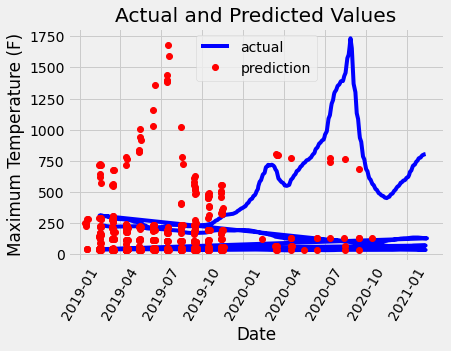

In [36]:
# Use datetime for creating date objects for plotting
import datetime
# Dates of training values
months = smoothed_df[:, smoothed_df_list.index('month')]
days = smoothed_df[:, smoothed_df_list.index('day')]
years = smoothed_df[:, smoothed_df_list.index('year')]
# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dates of predictions
months = test_features[:, smoothed_df_list.index('month')]
days = test_features[:, smoothed_df_list.index('day')]
years = test_features[:, smoothed_df_list.index('year')]
# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]


# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})
# Plot the actual values
plt.plot(true_data['date'], true_data['4. close'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');